## Import dependencies

In [1]:
# COCO related libraries
import sys
import os
sys.path.append(os.path.join("/mnt/samples/coco/"))  # To find local version
import coco
from pycocotools.coco import COCO

# MaskRCNN libraries
from mrcnn import utils, visualize
from mrcnn import model as modellib

# Misc
import cv2
import argparse as argparse
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io
import scipy
import random
import json
%matplotlib inline 

Using TensorFlow backend.


## Constants

In [2]:
# Number of classes in dataset. Must be of type integer
NUM_CLASSES = 9

# Relative path to .h5 weights file
WEIGHTS_FILE = "/mnt/MaskRCNNJupyterSuite-master/logs/tomato_train_weights20201007T0727/mask_rcnn_tomato_train_weights_0030.h5"

# Relative path to annotations JSON file
ANNOTATIONS_FILE = "/mnt/Annotations/Train/annotations.json"

# Relative path to directory of images that pertain to annotations file
ANNOTATION_IMAGE_DIR = "/mnt/Annotations/Train/"

# Relative path to the directory of images that you want to run inferencing on
TEST_IMAGE_DIR = "/mnt/images/Dataset"

## Additional Setup

In [3]:
# Set the ROOT_DIR variable to the root directory of the Mask_RCNN git repo
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Select which GPU to use
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="0";  

## Declare inference configuration

In [4]:
class InferenceConfig(coco.CocoConfig):
    # Train on 1 image per GPU. Batch size is 1 (GPUs * images/GPU).
    # GPU COUNT is modified so that its actually the id of the GPU you want to use. For example, to use the 4th GPU
    # put 3 for GPU count (0 index)
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + NUM_CLASSES  # background + 1 (structure)

    # All of our training images are 300x300
    IMAGE_MIN_DIM = 800
    IMAGE_MAX_DIM = 1024
    
    # Matterport originally used resnet101, but I downsized to fit it on my graphics card
    BACKBONE = 'resnet50'

    # RPN Anchor Scales
    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)
    
    # Changed to 512 because that's how many the original MaskRCNN paper used
    TRAIN_ROIS_PER_IMAGE = 200
    MAX_GT_INSTANCES = 114
    POST_NMS_ROIS_INFERENCE = 1000 
    POST_NMS_ROIS_TRAINING = 2000 
    
    DETECTION_MAX_INSTANCES = 114
    DETECTION_MIN_CONFIDENCE = 0.1
    
    STEPS_PER_EPOCH = 180
    VALIDATION_STEPS = 10

## Display configuration

In [5]:
InferenceConfig().display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        114
DETECTION_MIN_CONFIDENCE       0.1
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                22
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTAN

## Create class to load dataset

In [6]:
class CocoLikeDataset(utils.Dataset):
    """ Generates a COCO-like dataset, i.e. an image dataset annotated in the style of the COCO dataset.
        See http://cocodataset.org/#home for more information.
    """
    def load_data(self, annotation_json, images_dir):
        """ Load the coco-like dataset from json
        Args:
            annotation_json: The path to the coco annotations json file
            images_dir: The directory holding the images referred to by the json file
        """
        # Load json from file
        json_file = open(annotation_json)
        coco_json = json.load(json_file)
        json_file.close()
        
        # Add the class names using the base method from utils.Dataset
        source_name = "coco_like"
        for category in coco_json['categories']:
            class_id = category['id']
            class_name = category['name']
            if class_id < 1:
                print('Error: Class id for "{}" cannot be less than one. (0 is reserved for the background)'.format(class_name))
                return
            
            self.add_class(source_name, class_id, class_name)
        
        # Get all annotations
        annotations = {}
        for annotation in coco_json['annotations']:
            image_id = annotation['image_id']
            if image_id not in annotations:
                annotations[image_id] = []
            annotations[image_id].append(annotation)
        
        # Get all images and add them to the dataset
        seen_images = {}
        for image in coco_json['images']:
            image_id = image['id']
            if image_id in seen_images:
                print("Warning: Skipping duplicate image id: {}".format(image))
            else:
                seen_images[image_id] = image
                try:
                    image_file_name = image['file_name']
                    image_width = image['width']
                    image_height = image['height']
                except KeyError as key:
                    print("Warning: Skipping image (id: {}) with missing key: {}".format(image_id, key))
                
                image_path = os.path.abspath(os.path.join(images_dir, image_file_name))
                image_annotations = annotations[image_id]
                
                # Add the image using the base method from utils.Dataset
                self.add_image(
                    source=source_name,
                    image_id=image_id,
                    path=image_path,
                    width=image_width,
                    height=image_height,
                    annotations=image_annotations
                )
        
                     
    def load_mask(self, image_id):
        """ Load instance masks for the given image.
        MaskRCNN expects masks in the form of a bitmap [height, width, instances].
        Args:
            image_id: The id of the image to load masks for
        Returns:
            masks: A bool array of shape [height, width, instance count] with
                one mask per instance.
            class_ids: a 1D array of class IDs of the instance masks.
        """
        image_info = self.image_info[image_id]
        annotations = image_info['annotations']
        instance_masks = []
        class_ids = []
        
        for annotation in annotations:
            class_id = annotation['category_id']
            mask = Image.new('1', (image_info['width'], image_info['height']))
            mask_draw = ImageDraw.ImageDraw(mask, '1')
            for segmentation in annotation['segmentation']:
                mask_draw.polygon(segmentation, fill=1)
                bool_array = np.array(mask) > 0
                instance_masks.append(bool_array)
                class_ids.append(class_id)

        mask = np.dstack(instance_masks)
        class_ids = np.array(class_ids, dtype=np.int32)
        
        return mask, class_ids

## Load dataset to get list of class names

In [7]:
coco_dataset = CocoLikeDataset()
coco_dataset.load_data(ANNOTATIONS_FILE, ANNOTATION_IMAGE_DIR)
coco_dataset.prepare()
class_names = coco_dataset.class_names
class_id = coco_dataset.class_ids

## Build MaskRCNN Model

In [8]:
model = modellib.MaskRCNN(mode = "inference", model_dir = MODEL_DIR, config = InferenceConfig())

W1020 08:09:50.705744 140189551335232 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1020 08:09:50.725606 140189551335232 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1020 08:09:50.729795 140189551335232 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1020 08:09:50.754790 140189551335232 deprecation_wrapper.py:119] From /usr/local/anaconda/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1919: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm inste

## Load weights into model

In [9]:
model.load_weights(WEIGHTS_FILE, by_name = True)

Re-starting from epoch 30


## Run detection model

Processing 1 images
image                    shape: (3264, 4912, 3)       min:    0.00000  max:  255.00000  uint8


/usr/local/anaconda/lib/python3.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 4912.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


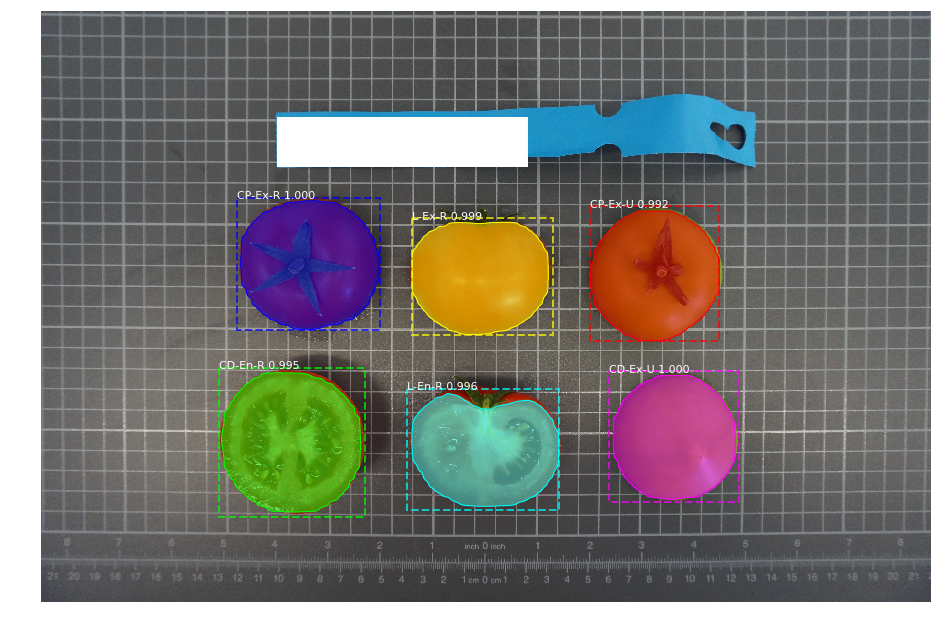

In [10]:
# Load a random image from the images folder
file_names = next(os.walk(TEST_IMAGE_DIR))[2]
# image = skimage.io.imread(os.path.join(TEST_IMAGE_DIR, random.choice(file_names)))

image = skimage.io.imread("/mnt/images/test2/Sa_532.jpg", plugin='matplotlib')

# Run detection
results = model.detect([image], verbose=1)

# Visualize results
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], class_names, r['scores'])

In [11]:
# Generate empty arrays for all the measurements we need
FileName = []
TomatoView = []

# Fruit Size
MaxHeight = []
CmHeight = []
MaxWidth = []
CmWidth = []
Area = []
CmArea = []

# Fruit Shape
ShapeIndex = []
ShapeTriangle = []
ShapeEccentric = []
IndexObovoid = []
IndexOvoid = []
AsymmetryHorizontal = []
AsymmetryVertical = []

# Fruit End Shape
AngleProx = []
AngleDist = []
BlockinessProx = []
BlockinessDist = []
ShoulderheightProx = []
ShoulderheightDist = []

# Fruit Shape Resemblance
Compactness = []
CompactnessEllipse = []
HeartP = []
HeartD = []
Rectangular = []



In [12]:
# Image Type
def Image_Type(image_name):
    # Determine if the image contains a grid
    img = cv2.imread(image_name)

    # Converting image to grayscale and finding the edges of the objects
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(gray, 200, 200, apertureSize=3)

    # Finding the contours in the image to extract the grid
    cnts = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    for c in cnts:
        cv2.drawContours(img, [c], 0, (0, 255, 0), 3)

    if (len(cnts)) > 3000:
        ImageType = "Grid"
    else:
        ImageType = "Non grid"
        
    return ImageType

In [13]:
# Grid
def Grid_Scale(ImageType, image_name):
    print(ImageType)
    img = cv2.imread(image_name)
        
    # Measuring the image dimensions
    height, width = img.shape[:2]
    imgarea = np.multiply(height, width)
    
    # Converting image to grayscale and finding the edges of the objects
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edged = cv2.Canny(gray, 200, 200, apertureSize=3)

    # Finding the contours in the image to extract the grid
    cnts = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Initializing and storing the area of
    # the squares of the grid (which we can find by finding only the area's that are not too small or too large)
    # in an array
    sqarea = np.array([])

    for c in cnts:
        cv2.drawContours(img, [c], 0, (0, 255, 0), 3)
        area = cv2.contourArea(c)

        if imgarea/10000 < area < imgarea/500:
            sqarea = np.append(sqarea, area)
    # Measuring the mean area of the grid
    gridarea = np.mean(sqarea)
    #print(gridarea)

    # Calculating the amount of pixels per cm in the image
    pixelspercm = np.sqrt(gridarea)
    #print(pixelspercm)

    pixelsize = 1/pixelspercm
    #print(pixelsize)
        
    return pixelsize

In [14]:
# Ruler
def Ruler_Scale(classids, roishape, masks):
    for i in range(0, roishape[0]):
        classID = classids[i]
        if classID == 1:
            ruler = masks[:, :, i]
            height = sum(ruler)
            rulerheight = max(height)
            #print(rulerheight)
        
            width = []
            for j in range(ruler.shape[0]):
                width.append(sum(ruler[j,:]))
        
            rulerwidth = np.mean(width)
            #print(rulerwidth)
            
            rulerarea = sum(height)
            #print(rulerarea)
                
            pixelsize = 1/rulerwidth
            
    return pixelsize

In [15]:
# Fruit Size
def Fruit_Size(mask, pixelsize, MaxHeight, CmHeight, MaxWidth, CmWidth, Area, CmArea):
    #count all pixels in the mask that are positive to find the area of each mask
    height = sum(mask)
    maxheight = max(height)
    MaxHeight.append(maxheight)
    #print(maxheight)
    
    cmheight = maxheight*float(pixelsize)
    CmHeight.append(cmheight)
    #print(cmheight)
        
    width = []
    for j in range(mask.shape[0]):
        width.append(sum(mask[j,:]))
    
    maxwidth = max(width)
    MaxWidth.append(maxwidth)
    #print(maxwidth)
    
    for j in range(mask.shape[0]):    
        if width[j]!=0 and width[j-1]==0:
            firstpoint = j
                                        
        if width[j]!=0 and width[j+1]==0:
            lastpoint = j
            
    for j in range(mask.shape[1]):        
        if height[j]!=0 and height[j-1]==0:
            firstxpoint=j
                                        
        if height[j]!=0 and height[j+1]==0:
            lastxpoint = j
                                            
    cmwidth = maxwidth*float(pixelsize)
    CmWidth.append(cmwidth)
    #print(cmwidth)
            
    at_5percent = round(firstpoint+(lastpoint-firstpoint)*0.05)
    at_95percent = round(firstpoint+(lastpoint-firstpoint)*0.95)
            
    proxwidth = width[at_5percent]
    distwidth = width[at_95percent]
                        
    area = sum(height)
    Area.append(area)
    #print(area)
    
    pixelarea = float(pixelsize)*float(pixelsize)
    cmarea = area*pixelarea
    CmArea.append(cmarea)
    #print(cmarea)
    
    return height, maxheight, MaxHeight, cmheight, CmHeight, firstpoint, lastpoint, firstxpoint, lastxpoint, width, maxwidth, MaxWidth, cmwidth, CmWidth, proxwidth, distwidth, area, cmarea, Area, CmArea

In [16]:
# Fruit Shape
def Fruit_Shape(maxheight, maxwidth, proxwidth, distwidth, firstpoint, lastpoint, firstxpoint, lastxpoint, mask, height, width, ShapeIndex, ShapeTriangle, IndexObovoid, IndexOvoid, ShapeEccentric, AsymmetryHorizontal, AsymmetryVertical):
    shapeindex = maxheight/maxwidth
    ShapeIndex.append(shapeindex)
            
    shapetriangle = proxwidth/distwidth
    ShapeTriangle.append(shapetriangle)
    
    mdif = []
    ndif = []
            
    for j in range(mask.shape[0]):
        if width[j] == maxwidth:
            widestindex = j
            y = j/(mask.shape[0])
 
        m = mask[j, round(firstxpoint+(lastxpoint-firstxpoint)*0.5)]
        mj = width[j]/2
        mdif.append(abs(m-mj))
        
    for j in range(mask.shape[1]):
        n = mask[round(firstpoint+(lastpoint-firstpoint)*0.5),j]
        nj = height[j]/2
        ndif.append(abs(n-nj))
        
    asymmetryhorizontal = sum(ndif)/(mask.shape[1])
    asymmetryvertical = sum(mdif)/(mask.shape[0])
            
    AsymmetryHorizontal.append(asymmetryhorizontal)
    AsymmetryVertical.append(asymmetryvertical)
    
    if y > 0.5:
        shapeeccentric = "Obovoid"
        indexobovoid = 4*(y-0.5)
        IndexObovoid.append(indexobovoid)
        IndexOvoid.append(None)
    else:
        shapeeccentric = "Ovoid"
        indexovoid = -4*(y-0.5)
        IndexOvoid.append(indexovoid)
        IndexObovoid.append(None)
    ShapeEccentric.append(shapeeccentric)
      
    return shapeindex, ShapeIndex, ShapeTriangle, IndexObovoid, IndexOvoid, ShapeEccentric, AsymmetryHorizontal, AsymmetryVertical, widestindex,y

In [35]:
# Fruit End Shape

In [36]:
# Fruit Shape Resemblance

8
Processing 1 images
image                    shape: (3264, 4912, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 4912.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[6 9 5 2 7 8]
Sa_538.jpg
Grid


/usr/local/anaconda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/anaconda/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


6
CP-Ex-R
9
L-Ex-R
5
CD-Ex-U
2
CD-En-R
7
CP-Ex-U
8
L-En-R


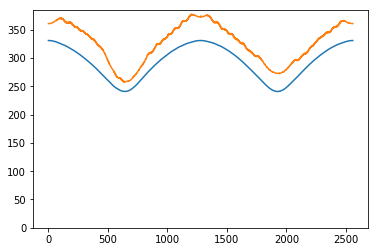

Processing 1 images
image                    shape: (3264, 4912, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 4912.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[5 6 9 8 2 7]
Sa_532.jpg
Grid
5
CD-Ex-U
6
CP-Ex-R
9
L-Ex-R
8
L-En-R


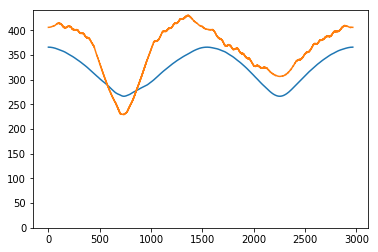

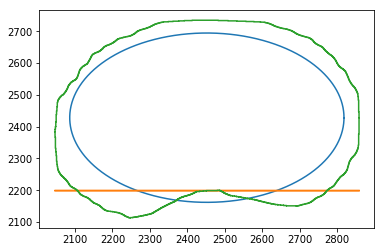

2
CD-En-R
7
CP-Ex-U
Processing 1 images
image                    shape: (3264, 4912, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 4912.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[9 5 6 2 7 8]
Sa_566.jpg
Grid
9
L-Ex-R
5
CD-Ex-U
6
CP-Ex-R
2
CD-En-R
7
CP-Ex-U
8
L-En-R


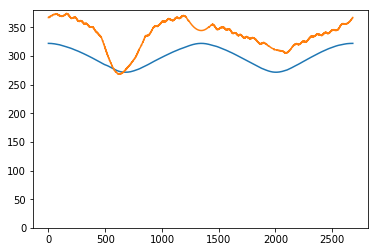

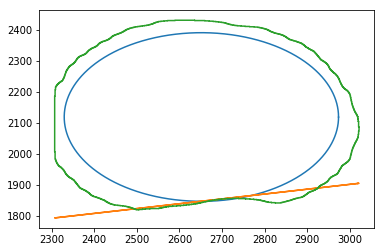

Processing 1 images
image                    shape: (3264, 4912, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 4912.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[6 9 5 8 2 7]
Sa_560.jpg
Grid
6
CP-Ex-R
9
L-Ex-R
5
CD-Ex-U
8
L-En-R


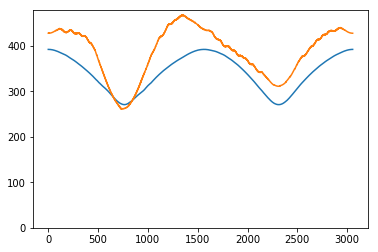

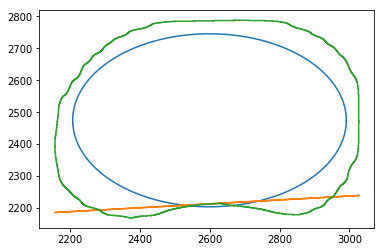

2
CD-En-R
7
CP-Ex-U
Processing 1 images
image                    shape: (3264, 4912, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 4912.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[6 9 5 2 8 7]
Sa_558.jpg
Grid
6
CP-Ex-R
9
L-Ex-R
5
CD-Ex-U
2
CD-En-R
8
L-En-R


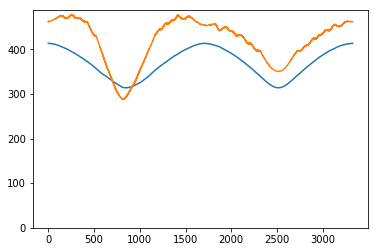

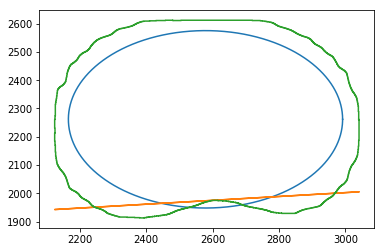

7
CP-Ex-U
Processing 1 images
image                    shape: (3264, 4912, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 4912.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[6 9 5 2 8 7]
Sa_535.jpg
Grid
6
CP-Ex-R
9
L-Ex-R
5
CD-Ex-U
2
CD-En-R
8
L-En-R


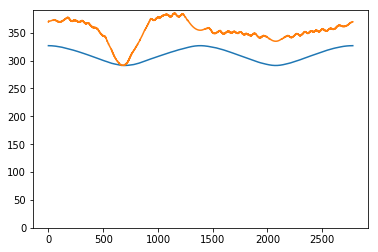

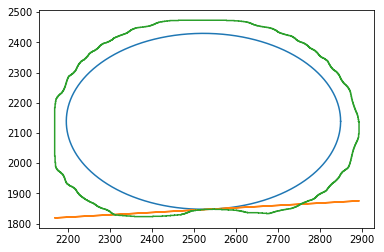

7
CP-Ex-U
Processing 1 images
image                    shape: (3264, 4912, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 4912.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[6 9 5 8 7 2]
Sa_559.jpg
Grid
6
CP-Ex-R
9
L-Ex-R
5
CD-Ex-U
8
L-En-R


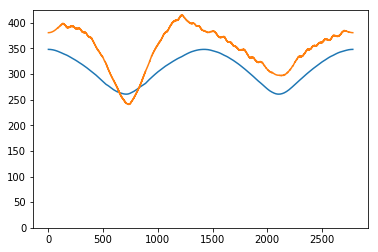

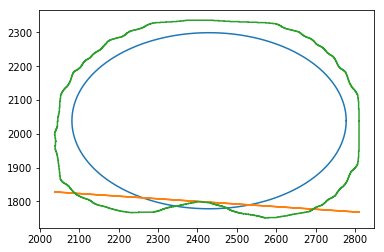

7
CP-Ex-U
2
CD-En-R
Processing 1 images
image                    shape: (2304, 3072, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 3072.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[6 7 9 1 8 3 4]
Sa_232.jpg
Ruler
6
CP-Ex-R
7
CP-Ex-U
9
L-Ex-R
1
Ruler
8
L-En-R


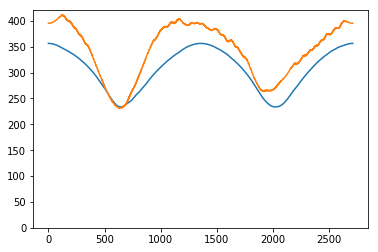

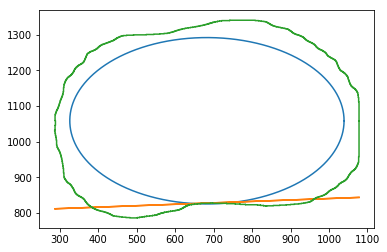

3
CD-En-U
4
CD-Ex-R


In [17]:
# load each image from the folder
list = os.listdir(TEST_IMAGE_DIR) # dir is your directory path
number_files = len(list)
print(number_files)

#results = model.detect([image], verbose=1)
#r = results[0]
#masks = r["masks"]
#roishape = r["rois"].shape
#classids = r["class_ids"]

for n in range(0, number_files):
    file_names = next(os.walk(TEST_IMAGE_DIR))[2]
    image_name = os.path.join(TEST_IMAGE_DIR, file_names[n])
    image = skimage.io.imread(image_name, plugin='matplotlib')
    #image_name = "/mnt/images/test2/Sa_532.jpg"
    
    results = model.detect([image], verbose=1)
    r = results[0]
    masks = r["masks"]
    roishape = r["rois"].shape
    classids = r["class_ids"]
    
    print(r["class_ids"])
   
    print(file_names[n])
    # image = skimage.io.imread(os.path.join(TEST_IMAGE_DIR, file_names[n]))
    
    # Determine if the image contains a grid or not
    ImageType = Image_Type(image_name)
    
    
    # If it is a grid image, calculate the scale for the image
    if ImageType == "Grid":
        pixelsize = Grid_Scale(ImageType, image_name)
    
    # Check if the image contains a Ruler and calculate the scale of the image
    else:
        if 1 in classids:
            ImageType = "Ruler"
            print(ImageType)
            
            pixelsize = Ruler_Scale(classids, roishape, masks)
        else: 
            ImageType = "No indicator" 
            print("Image does not contain a scale indicator")
        

    if ImageType == "Ruler" or ImageType == "Grid":
        # loop over of the detected object's bounding boxes and masks
        for i in range(0, len(classids)):
            # extract the class ID, classnames and mask for the current detection
            classID = classids[i]
            classnames = class_names[classID]
            mask = masks[:, :, i]
            intmask = mask.astype(int)
    
            print(classID)
            print(classnames)
            
            FileName.append(list[n])
            TomatoView.append(class_names[classID])
    
            height, maxheight, MaxHeight, cmheight, CmHeight, firstpoint, lastpoint, firstxpoint, lastxpoint, width, maxwidth, MaxWidth, cmwidth, CmWidth, proxwidth, distwidth, area, cmarea, Area, CmArea = Fruit_Size(mask, pixelsize, MaxHeight, CmHeight, MaxWidth, CmWidth, Area, CmArea)
                        
            shapeindex, ShapeIndex, ShapeTriangle, IndexObovoid, IndexOvoid, ShapeEccentric, AsymmetryHorizontal, AsymmetryVertical, widestindex, y = Fruit_Shape(maxheight, maxwidth, proxwidth, distwidth, firstpoint, lastpoint, firstxpoint, lastxpoint, mask, height, width, ShapeIndex, ShapeTriangle, IndexObovoid, IndexOvoid, ShapeEccentric, AsymmetryHorizontal, AsymmetryVertical)
            
            compactness = 4*cmarea/(np.pi*(cmheight**2))
            Compactness.append(compactness)
            
            compactnessellipse = 4*cmarea/(np.pi*cmheight*cmwidth)
            CompactnessEllipse.append(compactnessellipse)
            
            # find the coordinates of the edges of the mask
            edge = np.argwhere(intmask)
            edge[:, 0], edge[:, 1] = edge[:, 1], edge[:, 0].copy()
        
            # calculate the centroid position
            length = edge.shape[0]
            sum_x = np.sum(edge[:, 0])
            sum_y = np.sum(edge[:, 1])
            centroidx = sum_x/length
            centroidy = sum_y/length
        
            #print(centroidx)
            #print(centroidy)
            
            # a mask array to be able to show the mask outline
            edges = scipy.ndimage.distance_transform_cdt(intmask) == 1
            perimeter = sum(sum(edges))
            #print(perimeter)
            perimeter_fraction = round(0.02*perimeter) # Take 2% of perimeter to define the points to calculate proximal and distal angles
        
            edge2 = np.argwhere(edges == 1)
            edge2[:, 0], edge2[:, 1] = edge2[:, 1], edge2[:, 0].copy()
        
            R = []
            # Compute distances between center and mask outline
            for j in range(len(edge2)):
                r = np.sqrt((edge2[j,0]-centroidx)**2+(edge2[j,1]-centroidy)**2) # Distance for each point on the mask
                R.append(r) # Array of all distances
        
            Angle = []        
            # Using vector formulas to find the angle between top point and all other points. 
            for j in range(len(edge2[:,1])):
                xdif = edge2[j,0] - centroidx
                ydif = edge2[j,1] - centroidy
                     
                if ydif<=0 and xdif>0:
                    angle = np.arctan(-ydif/xdif)
                elif ydif<0 and xdif<=0:
                    angle = np.pi - np.arctan(-ydif/-xdif)
                elif ydif>=0 and xdif<0:    
                    angle = np.arctan(ydif/-xdif) + np.pi
                elif ydif>0 and xdif>=0:
                    angle = 2*np.pi - np.arctan(ydif/xdif)
                Angle.append(angle)
            
            distances = np.column_stack((R, Angle))
            #print(distances)
        
            sorted1 = np.argsort(distances[:, 1])
            sortlength = len(sorted1)
        
            sorted_distances = np.copy(distances)
            sorted_coords = np.copy(edge2)
        
            for j in range(sortlength):
                sorted_distances[j,:] = distances[sorted1[j], :]
                sorted_coords[j,:] = edge2[sorted1[j], :]
                
            rect_diag_start = firstpoint-shapeindex*firstxpoint
            #diag_length = np.sqrt(maxwidth**2+maxheight**2)
            Diag = []
            for m in range(sortlength):                    
                    if sorted_coords[m,1] == round(shapeindex*sorted_coords[m,0]+rect_diag_start):
                        Diag.append(sorted_coords[m,0])
                        Diag.append(sorted_coords[m,1])
                        Diag.append(m)
            #print(Diag)
            Sout = maxwidth*maxheight
            Sin = (Diag[len(Diag)-3]-Diag[0])*(Diag[len(Diag)-2]-Diag[1])
            rectangular = Sin/Sout
            Rectangular.append(rectangular)
            
            blockiness_prox = proxwidth/maxwidth
            blockiness_dist = distwidth/maxwidth
            BlockinessProx.append(blockiness_prox)
            BlockinessDist.append(blockiness_dist)
                    
            if classnames == "L-En-R":
                # calculating taperness
                wid1 = width[firstpoint:widestindex]
                w1 = np.mean(wid1)
                wid2 = width[widestindex:lastpoint]
                w2 = np.mean(wid2)
                taperness = 1-(w2/maxwidth)+(w1/maxwidth)
                
                # generating an ellipsoid that is somewhat smaller than the tomato's ellipse 
                # so that all the points from the tomato will fall outside the ellipse, except for the intentation
                ellipsex = ((maxwidth/2)*0.9)*np.cos(sorted_distances[:,1]) + centroidx #ellipsoid at 90% of tomato width
                ellipsey = ((maxheight/2)*0.9)*np.sin(sorted_distances[:,1]) + centroidy #and 90% of tomato height
                
                Ellipse = np.column_stack((ellipsex,ellipsey))
                half_sortlength = round(sortlength/2)
                
                El_distance = []
                p_dist = sorted_distances[1,0]
                d_dist = sorted_distances[half_sortlength,0]
                for m in range(sortlength):
                    distance = sorted_distances[m,0]
                    el_distance = np.sqrt((ellipsex[m]-centroidx)**2+(ellipsey[m]-centroidy)**2)
                    El_distance.append(el_distance)
                    if distance < el_distance and m <half_sortlength and distance<p_dist:
                        p_dist = distance
                    elif distance < el_distance and half_sortlength<m<sortlength and distance<d_dist:
                        d_dist = distance
                #print(p_dist)
                #print(d_dist)
                
                plt.plot(El_distance)                
                plt.plot(sorted_distances[:,0])
                plt.ylim(bottom=0)
                plt.show()
                
                P = []
                D = []
                Ap = []
                Bp = []
                Ad = []
                Bd = []
                # calculating shoulderheight
                dist_ = sorted_distances[:,0]
                dist_list = dist_.tolist()
                
                #If there is a proximal distance found, do calculations
                if p_dist!=sorted_distances[1,0]:
                    # p_dist = min(sorted_distances[0:half_sortlength,0]) # most indented proximal point P
                    p_index = dist_list.index(p_dist)
                    p_coord = sorted_coords[p_index,:]
                    #p_angle = sorted_distances[pp_index,1]
                    p_slope = (centroidx-p_coord[0])/(p_coord[1]-centroidy) # negative reciprocal of slope of line Centroid to P
                    p_start = p_coord[1]-p_slope*p_coord[0] # starting point of line through P
                    
                    plt.plot(ellipsex,ellipsey)
                    plt.plot(sorted_coords[:,0],p_slope*sorted_coords[:,0]+p_start)
                    #plt.plot(sorted_coords[:,0], shapeindex*sorted_coords[:,0]+rect_diag_start)
                    plt.plot(sorted_coords[:,0],sorted_coords[:,1])
                    plt.show()
                            
                    for m in range(sortlength):
                        if m < p_index:
                            edge_part = edge[m:p_index,:]
                            if p_index-m == perimeter_fraction: #p_index-m: amount of points (and thus length) between point p and m
                                first_coord = sorted_coords[m,:]
                                dx1 = abs(first_coord[0]-p_coord[0])
                                dy1 = abs(first_coord[1]-p_coord[1])
                        elif m > p_index: 
                            edge_part = edge[p_index:m,:]
                            if m-p_index == perimeter_fraction:
                                second_coord = sorted_coords[m,:]
                                dx2 = abs(second_coord[0]-p_coord[0])
                                dy2 = abs(second_coord[1]-p_coord[1])
                        
                        if sorted_coords[m,1] == round(p_slope*sorted_coords[m,0]+p_start):
                            P.append(sorted_coords[m,0])
                            P.append(sorted_coords[m,1])
                            P.append(m)
                            
                    p_angle = np.arctan(dx1/dy1)+np.arctan(dx2/dy2)
                 
                    Ap.append(P[0])
                    Ap.append(P[1])
                    Ap_index = P[2]
                
                    Bp.append(P[len(P)-3])
                    Bp.append(P[len(P)-2])
                    Bp_index = P[len(P)-1]
                    
                    if len(Ap)>0 and len(Bp)>0:
                        hp1=0
                        for m in range(Ap_index, p_index):
                            ypoint = (Bp[1]/Ap[1])*m+(Bp[1]*(1-(Bp[0]/Ap[1])))
                            hp = sorted_coords[m,1]-ypoint
                            if hp > hp1:
                                hp1 = hp
                        hp2=0
                        for m in range (p_index, Bp_index):
                            ypoint = (Bp[1]/Ap[1])*m+(Bp[1]*(1-(Bp[0]/Ap[1])))
                            hp = sorted_coords[m,1]-ypoint
                            if hp > hp2:
                                hp2 = hp
                            
                    shoulderheight_p = (hp1+hp2)/(2*maxheight)
                    ShoulderheightProx.append(shoulderheight_p)
                    
                    heartp = 0.25*((1-y)*taperness)+20*shoulderheight_p
                    HeartP.append(heartp)
                    
                    AngleProx.append(p_angle)
                else:
                    ShoulderheightProx.append(None)
                    HeartP.append(None)
                    AngleProx.append(None)
                    
                if d_dist!=sorted_distances[half_sortlength,0]:  
                    #print(d_dist)
                    # d_dist = min(sorted_distances[half_sortlength:sortlength,0]) # most indented distal point D
                    d_index = dist_list.index(d_dist)
                    d_coord = sorted_coords[d_index,:]
                    # d_angle = sorted_distances[pd_index,1]
                
                    d_slope = (centroidx-d_coord[0])/(d_coord[1]-centroidy) # negative reciprocal of slope of line Centroid to D
                    d_start = d_coord[1]-d_slope*d_coord[0] # starting point of line through P
                      
                    for m in range(sortlength): 
                        if m < d_index:
                            edge_part = edge[m:d_index,:]
                            if d_index-m == perimeter_fraction:
                                first_coord = sorted_coords[m,:]
                                dx1 = abs(first_coord[0]-p_coord[0])
                                dy1 = abs(first_coord[1]-p_coord[1])
                        elif m > d_index: 
                            edge_part = edge[d_index:m,:]
                            if m-d_index == perimeter_fraction:
                                second_coord = sorted_coords[m,:]
                                dx2 = abs(second_coord[0]-p_coord[0])
                                dy2 = abs(second_coord[1]-p_coord[1])
                        
                        if sorted_coords[m,1] == round(d_slope*sorted_coords[m,0]+d_start):
                            D.append(sorted_coords[m,0])
                            D.append(sorted_coords[m,1])
                            D.append(m)
                    
                    d_angle = np.arctan(dx1/dy1)+np.arctan(dx2/dy2)
                    
                    Ad.append(D[0])
                    Ad.append(D[1])
                    Ad_index = D[2]
                
                    Bd.append(D[len(D)-3])
                    Bd.append(D[len(D)-2])
                    Bd_index = D[len(D)-1]
                
                    plt.plot(ellipsex,ellipsey)
                    plt.plot(sorted_coords[:,0],d_slope*sorted_coords[:,0]+d_start)
                    plt.plot(sorted_coords[:,0],sorted_coords[:,1])
                    plt.show()
                        
                    if len(Ad)>0 and len(Bd)>0:
                        hd1=0
                        for m in range(Ad_index, d_index):
                            ypoint = (Bd[1]/Ad[1])*m+(Bd[1]*(1-(Bd[0]/Ad[1])))
                            hd = sorted_coords[m,1]-ypoint
                            if hd > hd1:
                                hd1 = hd
                        hd2=0
                        for m in range (d_index, Bd_index):
                            ypoint = (Bd[1]/Ad[1])*m+(Bd[1]*(1-(Bd[0]/Ad[1])))
                            hd = sorted_coords[m,1]-ypoint
                            if hd > hd2:
                                hd2 = hd
                
                    shoulderheight_d = (hd1+hd2)/(2*maxheight)
                    ShoulderheightDist.append(shoulderheight_d)
                
                    heartd = 0.25*((1-y)*taperness)+20*shoulderheight_d
                    HeartD.append(heartd)
                    
                    AngleDist.append(d_angle)
                else:
                    ShoulderheightDist.append(None)
                    HeartD.append(None)
                    AngleDist.append(None)
            else:
                ShoulderheightProx.append(None) 
                ShoulderheightDist.append(None)
                HeartP.append(None)
                HeartD.append(None)
                AngleProx.append(None)
                AngleDist.append(None)
        
Sizes = np.column_stack((FileName, TomatoView, MaxHeight, CmHeight, MaxWidth, CmWidth, Area, CmArea, ShapeIndex, ShapeTriangle, ShapeEccentric, IndexObovoid, IndexOvoid, AsymmetryHorizontal, AsymmetryVertical, AngleProx, AngleDist, BlockinessProx, BlockinessDist, ShoulderheightProx, ShoulderheightDist, Compactness, CompactnessEllipse, HeartP, HeartD, Rectangular))
Column_Names = ["File Name", "Type of Tomato Section", "Maximum Height (pixels)", "Maximum Height (cm)", "Maximum Width (pixels)", "Maximum Width (cm)", "Area (pixels)", "Area (cm)", "Shape Index", "Shape Triangle", "Eccentric", "Obovoid", "Ovoid", "Horizontal Asymmetry", "Vertical Asymmetry", "Proximal Angle (rad)", "Distal Angle (rad)", "Proximal Blockiness", "Distal Blockiness", "Proximal Shoulderheight", "Distal Shoulderheight", "Circular", "Ellipsoid", "Proximal Heart", "Distal Heart", "Rectangular"]

In [19]:
import pandas as pd
df = pd.DataFrame(Sizes)
df.columns = Column_Names

print(df)

df.to_excel('Tomato_Dataset.xlsx')

     File Name Type of Tomato Section Maximum Height (pixels)  \
0   Sa_538.jpg                CP-Ex-R                     720   
1   Sa_538.jpg                 L-Ex-R                     544   
2   Sa_538.jpg                CD-Ex-U                     657   
3   Sa_538.jpg                CD-En-R                     719   
4   Sa_538.jpg                CP-Ex-U                     691   
5   Sa_538.jpg                 L-En-R                     535   
6   Sa_532.jpg                CD-Ex-U                     684   
7   Sa_532.jpg                CP-Ex-R                     710   
8   Sa_532.jpg                 L-Ex-R                     618   
9   Sa_532.jpg                 L-En-R                     592   
10  Sa_532.jpg                CD-En-R                     768   
11  Sa_532.jpg                CP-Ex-U                     716   
12  Sa_566.jpg                 L-Ex-R                     620   
13  Sa_566.jpg                CD-Ex-U                     651   
14  Sa_566.jpg           